In [21]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, seed

from echo_state_network import ESN

Equation for the first pendulum: $mL\ddot{\theta_{1}} = -gmsin(\theta_{1}) - kL(sin(\theta_{1}) - sin(\theta_{2}))$

Equation for the second pendulum: $mL\ddot{\theta_{2}} = -gmsin(\theta_{2}) + kL(sin(\theta_{1}) - sin(\theta_{2}))$

# Equation independent of the second angle to get started

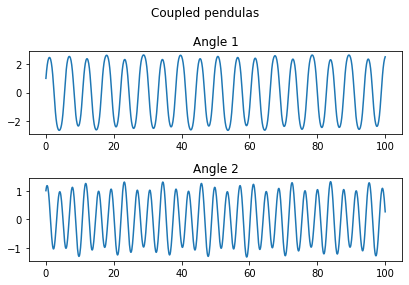

In [22]:
L_1 = 3
g_1 = 9.81
k_1 = 2
m_1 = 8

def coupled_pendulum(w, t, p):
    # x_i = theta_i
    # y_i = theta_i'
    # Return [theta1', theta1'', theta2', theta2'']
    # In our terminology: [y1, y1', y2, y2']
    
    x1, y1, x2, y2 = w
    g, L, k, m = p
    
    theta1_double_prime = - g/L * np.sin(x1) - k/m * np.sin(x1 - x2)
    theta2_double_prime = - g/L * np.sin(x2) + k/m * np.sin(x1 - x2)
    
    return [y1, theta1_double_prime, y2, theta2_double_prime]


def compute_L2(data1, data2):
    return ((data1 - data2) ** 2).sum()


def getESN(input_channels, n_reservoir, spectral_radius, sparsity, noise, teacher_forcing):
    return ESN(
        input_channels, 
        1, 
        n_reservoir=n_reservoir,
        spectral_radius=spectral_radius,
        sparsity=sparsity,
        noise=noise, 
        input_shift=None,
        input_scaling=None, 
        teacher_forcing=teacher_forcing, 
        feedback_scaling=None,
        teacher_scaling=None, 
        teacher_shift=None,
        out_activation=lambda x: x, #tanh, sigmoid
        inverse_out_activation=lambda x: x, #TODO ?
        random_state=None, 
        silent=False
    )

t = np.linspace(0, 100, num=1000)

# Pack up the parameters and initial conditions:
p = [g_1, L_1, k_1, m_1]

#Initial values
w0 = [1, 3, 1, 1]

abserr = 1.0e-8
relerr = 1.0e-6

# Call the ODE solver.
solution = odeint(coupled_pendulum, w0, t, args=(p,), atol=abserr, rtol=relerr)
angle1 = solution[:, 0]
angle2 = solution[:, 2]

fig, axs = plt.subplots(2)
fig.suptitle('Coupled pendulas')

axs[0].set_title('Angle 1')
axs[1].set_title('Angle 2')
fig.tight_layout()

axs[0].plot(t, angle1)
axs[1].plot(t, angle2)

# Analytic approximation

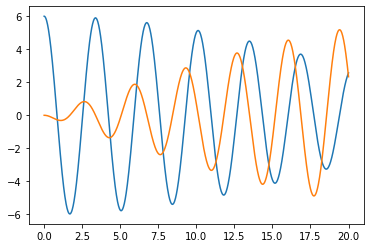

In [4]:
# https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_Mechanics_and_Relativity_(Idema)/08%3A_Oscillations/8.04%3A_Coupled_Oscillators
def compute_angles(time, initial_angle, k, g, l):
    omega_prime = np.sqrt(2 * k + g/l)
    omega_0 = np.sqrt(g/l)
    inner_term_1 = ((omega_0 + omega_prime) / 2) * t 
    inner_term_2 = ((omega_0 - omega_prime) / 2) * t
    
    angle1 = initial_angle * np.cos(inner_term_1) * np.cos(inner_term_2)
    angle2 = initial_angle * np.sin(inner_term_1) * np.sin(inner_term_2)
    
    return angle1, angle2

t = np.linspace(0, 20, 1000)
initial_angle = 6
k = 0.2
g = 9.81
l = 3

angle1, angle2 = compute_angles(t, initial_angle, k, g, l)

plt.plot(t, angle1, t, angle2)

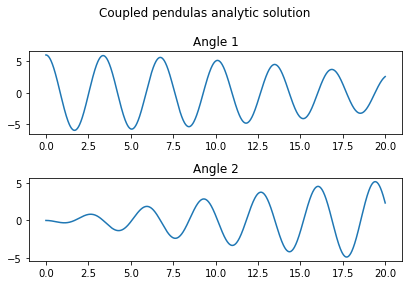

In [5]:
fig, axs = plt.subplots(2)
fig.suptitle('Coupled pendulas analytic solution')

axs[0].set_title('Angle 1')
axs[1].set_title('Angle 2')
fig.tight_layout()

axs[0].plot(t, angle1)
axs[1].plot(t, angle2)

# Predicting Angle 1 of coupled pendulum analytical solution with small angle approximation

harvesting states...
fitting...
training error:
0.20580481044361978
L^2 error 81.54462278797837


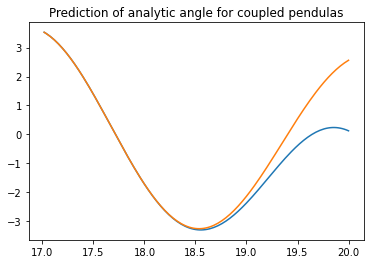

In [10]:
esn = getESN(1, 1000, 2, 0.1, 0, False)

cutoff = int(len(t) * 0.85)

training_data_output = angle1[:cutoff]
training_data_input = t[:cutoff]

validation_data_output = angle1[cutoff:]
validation_data_input = t[cutoff:]

weights = esn.fit(training_data_input, training_data_output)

prediction = esn.predict(validation_data_input)[:,0]

plt.plot(validation_data_input, prediction, validation_data_input, validation_data_output)
plt.title('Prediction of analytic angle for coupled pendulas')

print('L^2 error', compute_L2(validation_data_output, prediction))

# Introducing 2nd channel, the angle of the 2nd pendulum

harvesting states...
fitting...
training error:
0.20580596766288062


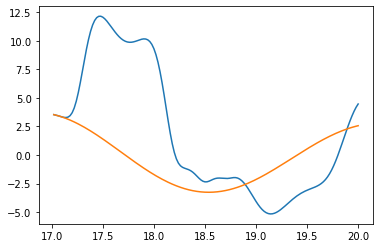

In [14]:
esn = getESN(2, 1000, 1, 0.3, 0, False)

angle_training_input = angle2[:cutoff]
time_training_input = t[:cutoff]

angle_validation_input = angle2[cutoff:]
time_validation_input = t[cutoff:]

training_data_input = np.column_stack((time_training_input, angle_training_input))
validation_data_input = np.column_stack((time_validation_input, angle_validation_input))

weights = esn.fit(training_data_input, training_data_output)

prediction = esn.predict(validation_data_input)[:,0]

plt.plot(time_validation_input, prediction, time_validation_input, validation_data_output)